In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Closed Form Solution:
$$S_{t+\Delta t}=S_t\text{exp}\left\{\left(r-\dfrac{1}{2}\sigma^2\right)\Delta t+\sigma\phi\sqrt{\Delta t}\right\}$$


In [2]:
def simulate_path_(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = horizon / timesteps
    S = np.zeros((timesteps, n_sims))
    S[0, :] = s0
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)
        S[i, :] = S[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * w)
    return S

Euler-Maruyama Scheme:

$$S_{t+\delta t}\sim S_t(1+r\delta t+\sigma\phi\sqrt{\delta t})$$

In [3]:
#Euler-Maruyama Scheme:
def simulate_path_EM(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = horizon / timesteps  # Time step
    S = np.zeros((timesteps, n_sims))  # Initialize stock price matrix
    S[0, :] = s0  # Set initial stock price
    
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)  # Standard normal random variable
        dW = np.sqrt(dt) * w  # Brownian motion increment
        
        S[i, :] = S[i-1, :] + mu * S[i-1, :] * dt + sigma * S[i-1, :] * dW
    
    return S

Milstein Scheme:

$$S_{t+\delta t}\sim S_t\left(1+r\delta t+\sigma\phi\sqrt{\delta t}+\dfrac{1}{2}\sigma^{2}\left(\phi^2-1\right)\delta t\right)$$


In [4]:
#Milstein Scheme:
def simulate_path_milstein(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = horizon / timesteps  # Time step
    S = np.zeros((timesteps, n_sims))  # Initialize stock price matrix
    S[0, :] = s0  # Set initial stock price
    
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)  # Standard normal random variable
        dW = np.sqrt(dt) * w  # Brownian motion increment
        
        # Milstein correction term
        correction = 0.5 * sigma**2 * S[i-1, :] * (dW**2 - dt)
        
        # Apply the Milstein update
        S[i, :] = S[i-1, :] + mu * S[i-1, :] * dt + sigma * S[i-1, :] * dW + correction
    
    return S

Text(0.5, 1.0, 'Simulated Geometric Brownian Motion at Maturity')

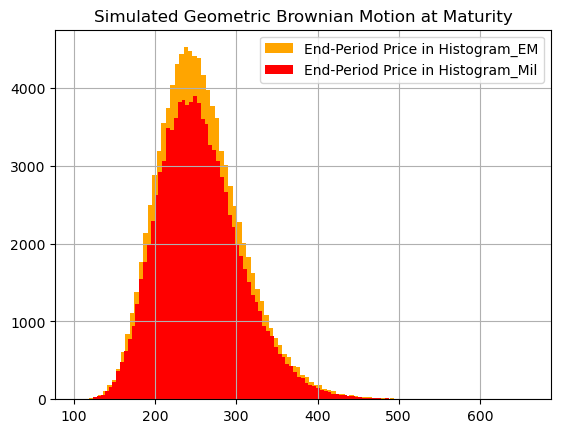

In [5]:
price_path = pd.DataFrame(simulate_path_EM(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='orange', label='End-Period Price in Histogram_EM')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

price_path = pd.DataFrame(simulate_path_milstein(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='red', label='End-Period Price in Histogram_Mil')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.

In each period, we compute

$$
X_i = \sum_{j=1}^{n_i} \left[ m \cdot \mathbf{1}\{\delta(s_{i,j} - K) \geq 0\} + G \cdot m \cdot \mathbf{1}\{\delta(s_{i,j} - K) < 0\} \right] \cdot \mathbf{1}(s_{i,j} < B)
$$

and

$$
A_i = \delta (S_i - K)
$$

Then the total present value is given by

$$
PV(t) = \mathbb{E} \left( \sum_{i=1}^{N} X_i A_i \cdot df(t_i, t) \right)
$$

where the discount factor at the settlement date of period \(i\) is defined as

$$
df(t_i, t) = e^{-r t_i}.
$$



In [6]:
def simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract='accumulator', seed=None):
    """
    Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.
    
    For each period, the simulation:
      - Accumulates shares daily based on:
          if delta*(price - B) < 0:
              if delta*(price - K) >= 0: accumulate m shares
              else: accumulate G * m shares
      - At the period's settlement date, calculates the payoff using:
          A_i = delta * (S_settlement - K)
          Payoff_i = (accumulated shares in period) * A_i, discounted to present.
    
    The total payoff is the sum over all periods.
    
    Returns:
        price: float, the estimated price of the ACDC contract.
    """
    n_steps = int(days_per_year * T)  # Total simulation steps; for 1 year, n_steps = 252
    S = simulate_path_milstein(S0, r, sigma, T, n_steps, N_paths, seed)
    delta = 1 if contract.lower() == 'accumulator' else -1
    period_indices = np.linspace(0, n_steps, N_periods + 1, dtype=int)
    period_payoffs = np.zeros((N_paths, N_periods))
    
    for i in range(N_periods):
        start_index = period_indices[i]
        # For the final period, use the full period so that t_settlement = n_steps/days_per_year
        if i == N_periods - 1:
            settlement_index = n_steps - 1  # Last index of S (i.e., day 251, which represents 252 days)
            t_settlement = n_steps / days_per_year  # t_settlement = 252/252 = 1 year
            S_settlement = S[settlement_index, :]
        else:
            settlement_index = period_indices[i + 1] - 1
            t_settlement = (settlement_index + 1) / days_per_year  # +1 to count days correctly
            S_settlement = S[settlement_index, :]
        
        X_i = np.zeros(N_paths)
        days_in_period = settlement_index - start_index + 1
        
        for day in range(days_in_period):
            for sim in range(N_paths):
                price = S[start_index + day, sim]
                if delta * (price - B) < 0:
                    if delta * (price - K) >= 0:
                        X_i[sim] += m  
                    else:
                        X_i[sim] += G * m  
                else:
                    X_i[sim] += 0
        
        A_i = delta * (S_settlement - K)
        discount_factor = np.exp(-r * t_settlement)
        period_payoff = X_i * A_i
        period_payoffs[:, i] = period_payoff * discount_factor
        
        # Print discount factor and the average discounted payoff for this period
        avg_payoff = np.mean(period_payoffs[:, i])
        #print(f"Period {i+1}: t_settlement = {t_settlement*days_per_year:.3f} days, discount_factor = {discount_factor:.9f}, avg discounted payoff = {avg_payoff:.4f}")
    
    total_payoffs = np.sum(period_payoffs, axis=1)
    price = np.mean(total_payoffs)
    return price

In [7]:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 110
    barrier_pct = 100.89
    r = 0.0507          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte aCarlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0*(strike_pct/100.0)          # strike price.
    B = S0*(barrier_pct/100.0)            # knock-out barrier.
    G = 2                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 399 #int or None, seed for reproducibility.
    price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
    print(f"Estimated price of the {contract_type} ACDC contract: {price:.4f}")


Estimated price of the accumulator ACDC contract: -9759.7577


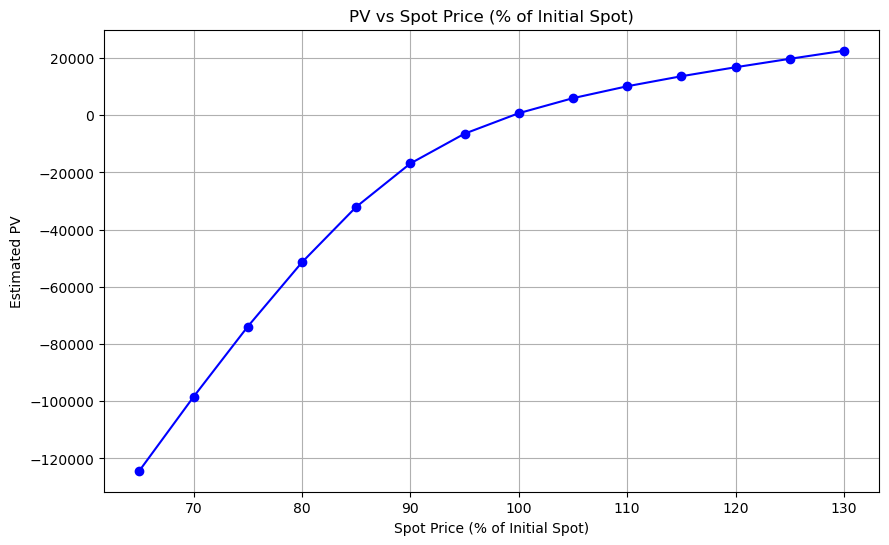

In [8]:
def plot_pv_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=None):
    """
    Simulate and plot the present value (PV)of the ACDC contract as a function of the initial spot price.
    
    Parameters:
        S0_range (array-like): Array of initial spot prices.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        T (float): Time to expiry in years.
        N_paths (int): Number of Monte Carlo simulation paths.
        N_periods (int): Number of settlement periods.
        days_per_year (int): Number of trading days per year.
        m (float): Number of shares accumulated per eligible day.
        strike_pct (float): Strike as a percentage of S0.
        barrier_pct (float): Barrier as a percentage of S0.
        G (float): Gearing factor.
        contract_type (str): Either 'accumulator' or 'decumulator'.
        seed (int or None): Seed for reproducibility.
    """
    # Define spot prices as a percentage of S0 from 65% to 130% in 5% increments
    spot_pct_range = np.arange(65, 135, 5)  # From 65% to 130% with 5% step
    S0_range = S0 * (spot_pct_range / 100.0)  # Convert percentage to actual spot prices

    PVs = []
    for S0 in S0_range:
        # Recalculate strike and barrier based on the current S0
        #K = S0 * (strike_pct / 100.0)
        #B = S0 * (barrier_pct / 100.0)
        # Call the simulation function (assumed to be defined elsewhere)
        price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
        PVs.append(price)
    PVs = np.array(PVs)
        
# Plot PV vs Spot Price (% of Initial Spot)
    plt.figure(figsize=(10, 6))
    plt.plot(spot_pct_range, PVs, marker='o', linestyle='-', color='b')
    plt.title('PV vs Spot Price (% of Initial Spot)')
    plt.xlabel('Spot Price (% of Initial Spot)')
    plt.ylabel('Estimated PV')
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    strike_pct = 90
    barrier_pct = 1000
    r = 0.0507          # risk-free rate (annualized).
    sigma = 0.2          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte Carlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = S0 * (strike_pct / 100.0)          # strike price.
    B = S0 * (barrier_pct / 100.0)         # knock-out barrier.
    G = 10                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 399          # seed for reproducibility.
    
    # Define a range of S0 values to explore
    #S0_range = np.linspace(138, 280, 140)
    
    # Plot PV, delta, and gamma versus spot percentage and store all data for each percentage in a file
    plot_pv_vs_spot(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, strike_pct, barrier_pct, G, contract_type, seed=seed)